# Preperation

In [3]:
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers import Input,merge
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten,MaxoutDense
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Deconv2D, UpSampling2D
from keras.layers.recurrent import LSTM
from keras.regularizers import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.datasets import mnist
import matplotlib.pyplot as plt
import seaborn as sns
import random, sys, keras
import pickle as cPickle
import cv2
import glob
from keras.models import Model
from IPython import display

sys.path.append("../common")
from keras.utils import np_utils
from tqdm import tqdm

Using TensorFlow backend.
/Users/jhsiao/anaconda/envs/py3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Load data

In [38]:
X_train = np.load("GAN_DS_YCrCb_km6.npy")

# Model
Came from https://github.com/osh/KerasGAN

In [39]:
'''get the shape and opt'''

shp = X_train.shape[1:]
print(shp)

dropout_rate = 0.25
# Optim

opt = Adam(lr=1e-3)
dopt = Adam(lr=1e-4)
#opt = Adam(lr=1e-3)
#opt = Adamax(lr=1e-4)
#opt = Adam(lr=0.0002)
#opt = Adam(lr=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-08)
nch = 200

(72, 72, 3)


In [40]:
'''generator'''

def generative_model(nch, shp):
    # Build Generative model ...
    g_input = Input(shape=[100])
    H = Dense(nch*((shp[0]//2)**2), init='glorot_normal')(g_input) # change this
    H = BatchNormalization(mode=2)(H)
    H = Activation('relu')(H)
    H = Reshape( [shp[0]//2, shp[0]//2, nch] )(H) # change this
    H = UpSampling2D(size=(2, 2))(H)
    H = Convolution2D(nch//2, 3, 3, border_mode='same', init='glorot_uniform')(H)
    H = BatchNormalization(mode=2)(H)
    H = Activation('relu')(H)
    H = Convolution2D(nch//4, 3, 3, border_mode='same', init='glorot_uniform')(H)
    H = BatchNormalization(mode=2)(H)
    H = Activation('relu')(H)
    H = Convolution2D(shp[2], 1, 1, border_mode='same', init='glorot_uniform')(H)
    g_V = Activation('sigmoid')(H)
    generator = Model(g_input,g_V)
    generator.compile(loss='binary_crossentropy', optimizer=opt)
    generator.summary()
    return generator

In [48]:
def discriminative_model(shp, dropout_rate=0.25):
    # Build Discriminative model ...
    d_input = Input(shape=shp)
    H = Convolution2D(256, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(d_input)
    H = LeakyReLU(0.2)(H)
    H = Dropout(dropout_rate)(H)
    H = Convolution2D(512, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(H)
    H = LeakyReLU(0.2)(H)
    H = Dropout(dropout_rate)(H)
    H = Flatten()(H)
    H = Dense(256)(H)
    H = LeakyReLU(0.2)(H)
    H = Dropout(dropout_rate)(H)
    d_V = Dense(2,activation='softmax')(H)
    discriminator = Model(d_input,d_V)
    discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)
    discriminator.summary()
    return discriminator

In [42]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [43]:
def gan(nch, shp, dropout_rate=0.25):
    # Freeze weights in the discriminator for stacked training
    generator = generative_model(nch, shp)
    discriminator = discriminative_model(shp, dropout_rate)
    make_trainable(discriminator, False)
    # Build stacked GAN model
    gan_input = Input(shape=[100])
    H = generator(gan_input)
    gan_V = discriminator(H)
    GAN = Model(gan_input, gan_V)
    GAN.compile(loss='categorical_crossentropy', optimizer=opt)
    GAN.summary()
    return generator, discriminator, gan

# Plotting utils

In [25]:
def plot_loss(losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.figure(figsize=(10,8))
    plt.plot(losses["d"], label='discriminitive loss')
    plt.plot(losses["g"], label='generative loss')
    plt.legend()
    plt.show()
    
def plot_gen(generator, n_ex=16,dim=(4,4), figsize=(10,10) ):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()



# Train

In [49]:
G, D, GAN = gan(50, shp)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_13 (InputLayer)            (None, 100)           0                                            
____________________________________________________________________________________________________
dense_14 (Dense)                 (None, 64800)         6544800     input_13[0][0]                   
____________________________________________________________________________________________________
batchnormalization_16 (BatchNorm (None, 64800)         259200      dense_14[0][0]                   
____________________________________________________________________________________________________
activation_21 (Activation)       (None, 64800)         0           batchnormalization_16[0][0]      
___________________________________________________________________________________________

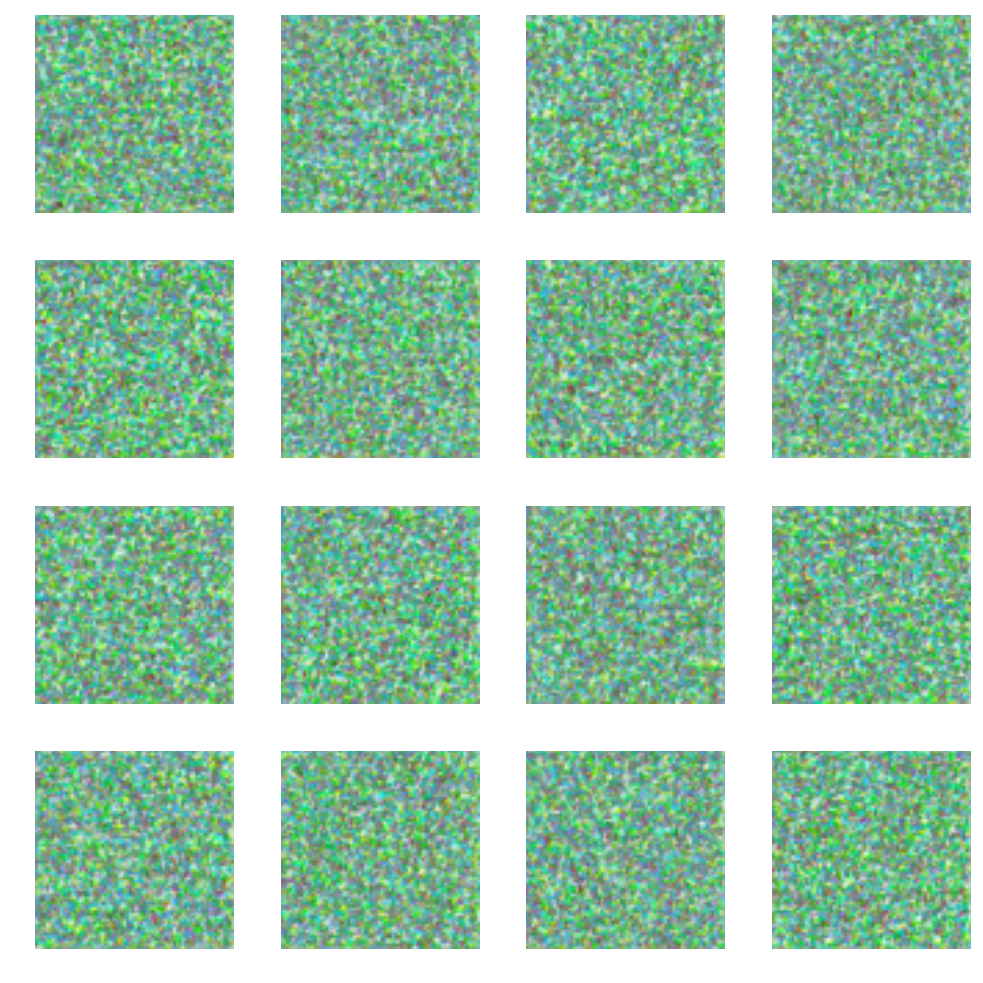

In [45]:
plot_gen(G)

In [46]:
'''train discriminator'''
def train_discriminator(generator, discriminator, XT, epoch=5, batch_size=32):
    # Pre-train the discriminator network ...
    noise_gen = np.random.uniform(0,1,size=[XT.shape[0],100])
    generated_images = generator.predict(noise_gen)
    X = np.concatenate((XT, generated_images))
    n = XT.shape[0]
    y = np.zeros([2*n,2])
    y[:n,1] = 1
    y[n:,0] = 1

    make_trainable(discriminator,True)
    discriminator.fit(X,y, nb_epoch=epoch, batch_size=batch_size)

In [ ]:
train_discriminator(G, D, X_train)

Epoch 1/5
692/692 [==============================] - 166s - loss: 0.3642   
Epoch 2/5
692/692 [==============================] - 91s - loss: 3.6472e-04    
Epoch 3/5
256/692 [==========>...................] - ETA: 56s - loss: 3.7942e-04

In [ ]:
# set up loss storage vector
losses = {"d":[], "g":[]}
def train_for_n(nb_epoch=5000, plt_frq=25,BATCH_SIZE=32):

    for e in tqdm(range(nb_epoch)):  
        
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]    
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict(noise_gen)
        
        # Train discriminator on generated images
        # CHANGE THIS TO change the 0,1 distribution
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        make_trainable(discriminator,True)
        d_loss  = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)
    
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        
        make_trainable(discriminator,False)
        g_loss = GAN.train_on_batch(noise_tr, y2 )
        losses["g"].append(g_loss)
        
        # Updates plots
        if e%plt_frq==plt_frq-1:
            plot_loss(losses)
            plot_gen()
        

In [ ]:
K.set_value(opt.lr, 1e-4)
K.set_value(dopt.lr, 1e-5)
train_for_n(nb_epoch=40, plt_frq=5,BATCH_SIZE=128)